In [1]:
#Importar el drive para usar el dataset y carga de librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from seaborn import violinplot
from sklearn.preprocessing import LabelEncoder


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Ruta del archivo en Google Drive
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    name=fn
counter = pd.read_csv(name, sep=";")

Saving Anexo ET_demo_round_traces_2022.csv to Anexo ET_demo_round_traces_2022.csv


<ipython-input-2-e48695eea88a>:6: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  counter = pd.read_csv(name, sep=";")


## Fase 3: Data Preparation

In [3]:
counter_backup = counter.copy()

In [4]:
counter_backup.drop(columns=['FirstKillTime'], inplace=True)
counter_backup.drop(columns=['TimeAlive'], inplace=True)
counter_backup.drop(columns=['TravelledDistance'], inplace=True)

### Eliminacion de datos atipicos

In [5]:
counter_backup.drop(counter_backup[counter_backup['MatchKills'] > 28].index, inplace=True)
counter_backup.shape

(78995, 27)

In [6]:
counter_backup.drop(counter_backup[counter_backup['MatchAssists'] > 8].index, inplace=True)
counter_backup.shape

(78710, 27)

In [7]:
label_encoder = LabelEncoder()
counter_backup['Team'] = label_encoder.fit_transform(counter_backup['Team'])
counter_backup['Map'] = label_encoder.fit_transform(counter_backup['Map'])

In [8]:
counter_backup['Map'].unique()

array([1, 3, 2, 0])

### Transformar datos booleanos

In [ ]:
counter_backup.RoundWinner = counter_backup.RoundWinner.astype(bool)
counter_backup.MatchWinner = counter_backup.MatchWinner.astype(bool)
# Conversion
counter_backup.RoundWinner.replace({True: 1, False: 0}, inplace=True)
counter_backup.MatchWinner.replace({True: 1, False: 0}, inplace=True)
counter_backup.Survived.replace({True: 1, False: 0}, inplace=True)

In [10]:
# Revisiom
counter_backup.info()
# Vista previa
counter_backup.head()

<class 'pandas.core.frame.DataFrame'>
Index: 78710 entries, 0 to 79156
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   78710 non-null  int64  
 1   Map                          78710 non-null  int64  
 2   Team                         78710 non-null  int64  
 3   InternalTeamId               78710 non-null  int64  
 4   MatchId                      78710 non-null  int64  
 5   RoundId                      78710 non-null  int64  
 6   RoundWinner                  78710 non-null  int64  
 7   MatchWinner                  78710 non-null  int64  
 8   Survived                     78710 non-null  int64  
 9   AbnormalMatch                78710 non-null  bool   
 10  RLethalGrenadesThrown        78710 non-null  int64  
 11  RNonLethalGrenadesThrown     78710 non-null  int64  
 12  PrimaryAssaultRifle          78710 non-null  float64
 13  PrimarySniperRifle   

,Unnamed: 0,Map,Team,InternalTeamId,MatchId,RoundId,RoundWinner,MatchWinner,Survived,AbnormalMatch,...,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots
0,600,1,1,1,4,1,1,1,0,False,...,0,0,0,0,750,4400,0,0,0,0
1,601,1,1,1,4,1,1,1,0,False,...,0,0,0,0,800,4400,0,0,0,0
2,602,1,1,1,4,1,1,1,0,False,...,0,0,0,0,1000,4400,0,0,0,0
3,603,1,1,1,4,1,1,1,0,False,...,0,0,0,0,850,4400,0,0,0,0
4,604,1,1,1,4,1,1,1,1,False,...,0,0,0,0,1000,4400,0,0,0,0


In [11]:
# Limitar numero de rondas
counter_backup = counter_backup[(counter_backup['RoundId'] >= 1) & (counter_backup['RoundId'] <= 30)]

counter_backup['RoundId'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

### Support Vector Machine


COMPARACIÓN ENTRENAMIENTO vs PRUEBA
----------------------------------
Métrica		Entrenamiento	Prueba
R²		 -0.114	 -0.124
MAE		   0.65	   0.65
MSE		   0.87	   0.87


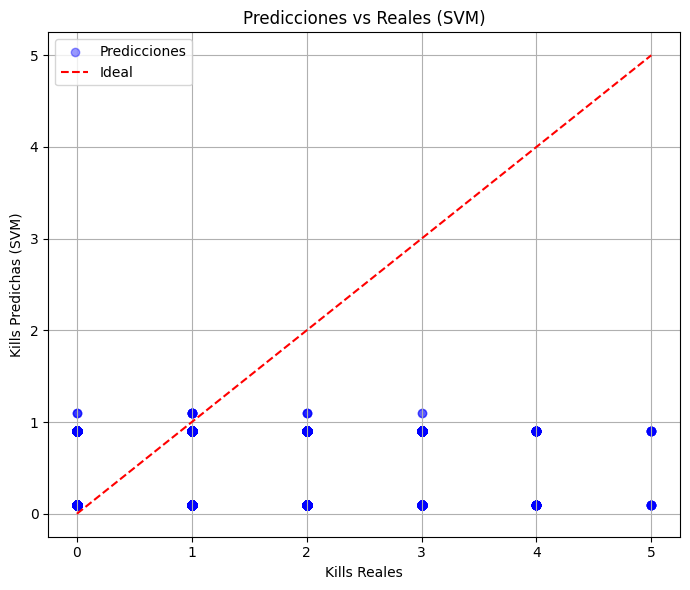

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Variables: RLethalGrenadesThrown (X) y RoundKills (y)
X = counter_backup[['RLethalGrenadesThrown']]
y = counter_backup['RoundKills']

# División de los datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Definición del modelo SVM con kernel RBF y escalado
svm_model = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=10.0, epsilon=0.1)
)

# Entrenamiento del modelo
svm_model.fit(X_train, y_train)

# Predicciones
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

# Métricas de evaluación
print("\nCOMPARACIÓN ENTRENAMIENTO vs PRUEBA")
print("----------------------------------")
print("Métrica\t\tEntrenamiento\tPrueba")
print(f"R²\t\t{r2_score(y_train, y_train_pred):>7.3f}\t{r2_score(y_test, y_test_pred):>7.3f}")
print(f"MAE\t\t{mean_absolute_error(y_train, y_train_pred):>7.2f}\t{mean_absolute_error(y_test, y_test_pred):>7.2f}")
print(f"MSE\t\t{mean_squared_error(y_train, y_train_pred):>7.2f}\t{mean_squared_error(y_test, y_test_pred):>7.2f}")

# Gráfico: kills reales vs predichos
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_test_pred, alpha=0.4, color='blue', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal')
plt.xlabel('Kills Reales')
plt.ylabel('Kills Predichas (SVM)')
plt.title('Predicciones vs Reales (SVM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()